In [12]:
# Step 1: Data Preparation

import pandas as pd
# Loading the dataset
time_series_data = pd.read_csv('ts6.csv')
# Rename columns for clarity. considering unnamed column to 'Time' and 'x' to Value.
time_series_data.rename(columns={'Unnamed: 0': 'Time', 'x': 'Value'}, inplace=True)
# Checking for missing values
missing_values = time_series_data.isnull().sum()
print(missing_values)
if missing_values.any():
    time_series_data['Value'].fillna(method='ffill', inplace=True)

Time     0
Value    0
dtype: int64


Summary Statistics:
              Time       Value
count  401.000000  401.000000
mean   201.000000  215.988071
std    115.902977   44.187797
min      1.000000  108.099998
25%    101.000000  184.309998
50%    201.000000  214.240005
75%    301.000000  251.449997
max    401.000000  309.070007


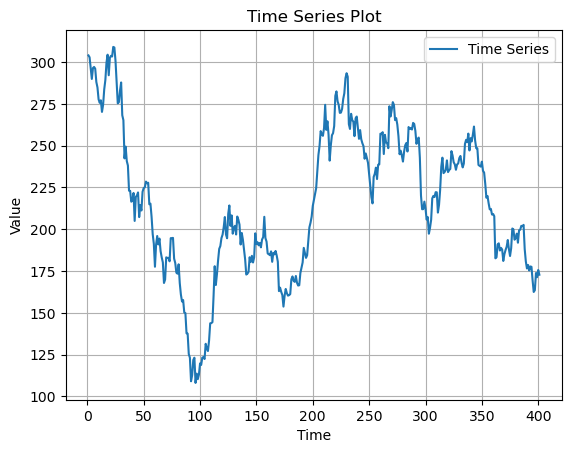

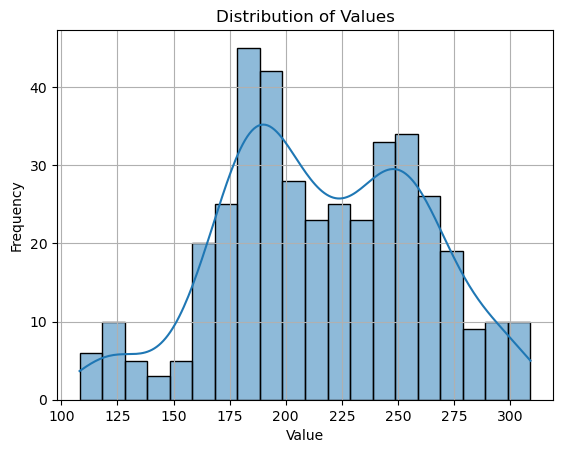

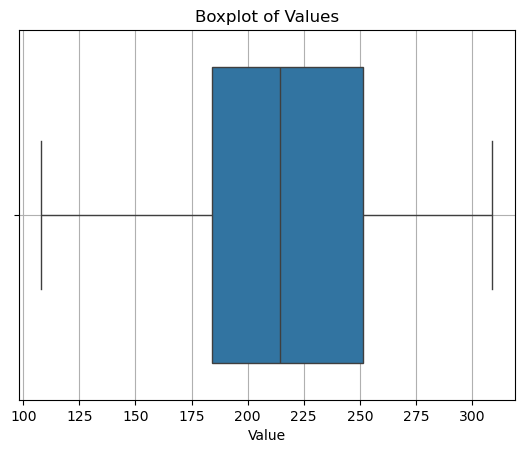

In [13]:
# Step 2: Exploratory Data Analysis (EDA)
import matplotlib.pyplot as plt
import seaborn as sns
# 2.1. Summary statistics
print("Summary Statistics:\n", time_series_data.describe())

# 2.2. Ploting the time series
plt.plot(time_series_data['Time'], time_series_data['Value'], label='Time Series')
plt.title('Time Series Plot')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.grid()
plt.show()

# 2.3. Distribution of the values
sns.histplot(time_series_data['Value'], kde=True, bins=20)
plt.title('Distribution of Values')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.grid()
plt.show()

# 2.4. Boxplot for identifying outliers
sns.boxplot(x=time_series_data['Value'])
plt.title('Boxplot of Values')
plt.xlabel('Value')
plt.grid()
plt.show()

In [3]:
# Step 3: Stationarity Testing
from statsmodels.tsa.stattools import adfuller, kpss
# ADF Test
def adf_test(series):
    result = adfuller(series)
    print("ADF Statistic:", result[0])
    print("p-value:", result[1])
    print("Critical Values:", result[4])
    if result[1] < 0.05:
        print("The series is stationary.")
    else:
        print("The series is not stationary.")

# KPSS Test
def kpss_test(series):
    result = kpss(series, regression='c', nlags="auto")
    print("KPSS Statistic:", result[0])
    print("p-value:", result[1])
    print("Critical Values:", result[3])
    if result[1] > 0.05:
        print("The series is stationary.")
    else:
        print("The series is not stationary.")

print("ADF Test:")
adf_test(time_series_data['Value'])

print("\nKPSS Test:")
kpss_test(time_series_data['Value'])

ADF Test:
ADF Statistic: -2.59159197180227
p-value: 0.09474751769658252
Critical Values: {'1%': -3.4471856790801514, '5%': -2.868960436182993, '10%': -2.5707229006220524}
The series is not stationary.

KPSS Test:
KPSS Statistic: 0.34988594889782243
p-value: 0.09875605650955929
Critical Values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}
The series is stationary.


In [4]:
# Step 4: Differencing
time_series_data['Diff'] = time_series_data['Value'].diff().dropna()
print("ADF Test After Differencing:")
adf_test(time_series_data['Diff'].dropna())

ADF Test After Differencing:
ADF Statistic: -8.694654395021306
p-value: 3.954845654405032e-14
Critical Values: {'1%': -3.4469717056192213, '5%': -2.868866381945153, '10%': -2.570672761197837}
The series is stationary.


Training set size: 320
Testing set size: 81


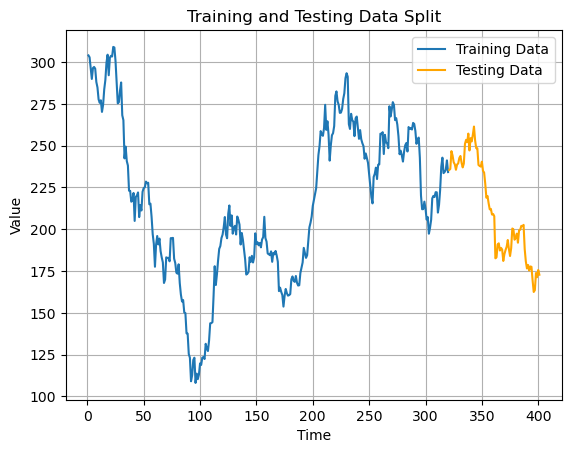

In [5]:
# Step 5: Train and Test Spliting
train_size = int(len(time_series_data) * 0.8)
train, test = time_series_data[:train_size], time_series_data[train_size:]
# Display the sizes of the splits
print(f"Training set size: {len(train)}")
print(f"Testing set size: {len(test)}")

# Ploting the training and testing data to visualize the split
plt.plot(train['Time'], train['Value'], label='Training Data')
plt.plot(test['Time'], test['Value'], label='Testing Data', color='orange')
plt.title('Training and Testing Data Split')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.grid()
plt.show()


In [6]:
# Step 6: Model Selection and Fitting
import itertools
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
p = d = q = range(0, 3)
pdq_combinations = list(itertools.product(p, d, q))
best_order = None
best_mse = float("inf")

for order in pdq_combinations:
    try:
        model = ARIMA(train['Value'], order=order)
        fitted = model.fit()
        forecast = fitted.forecast(steps=len(test))
        mse = mean_squared_error(test['Value'], forecast)
        if mse < best_mse:
            best_order = order
            best_mse = mse
    except:
        continue

print(f"Best ARIMA Order: {best_order}")
print(f"Best MSE: {best_mse}")

final_model = ARIMA(train['Value'], order=best_order).fit()


C:\installed\programs\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\installed\programs\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\installed\programs\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\installed\programs\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\installed\progra

Best ARIMA Order: (0, 0, 2)
Best MSE: 851.2357555239173


C:\installed\programs\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


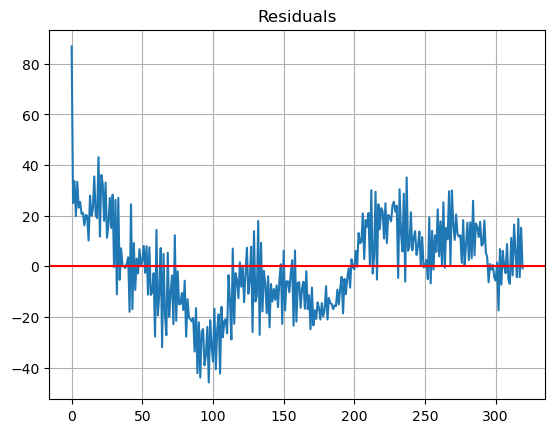

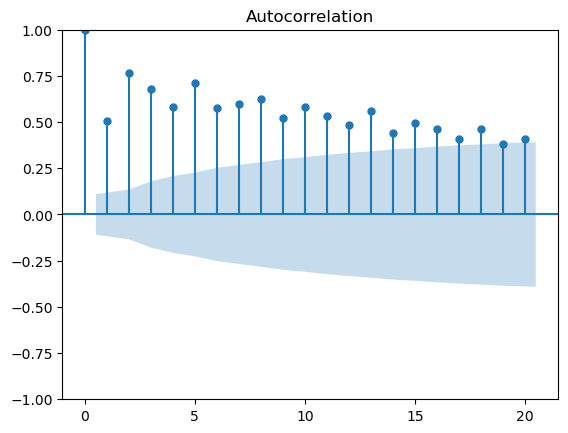

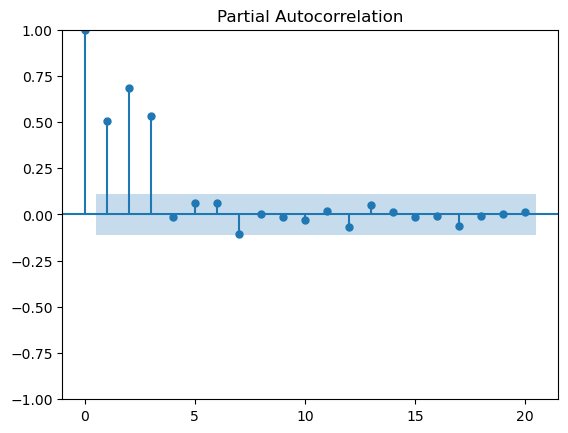

Ljung-Box Test:
         lb_stat      lb_pvalue
10  1257.823606  4.830463e-264


In [9]:
# Step 7: Diagnostics

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox

residuals = final_model.resid

# Residuals Analysis
plt.plot(residuals)
plt.axhline(0, color='red')
plt.title('Residuals')
plt.grid()
plt.show()

# ACF for residuals
plot_acf(residuals,lags=20)
plt.show()
# PACF for residuals
plot_pacf(residuals,lags=20)
plt.show()

# Ljung-Box Test
ljung_box = acorr_ljungbox(residuals, lags=[10], return_df=True)
print("Ljung-Box Test:\n", ljung_box)



C:\Users\seman\AppData\Local\Temp\ipykernel_18176\1820930299.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Forecast'] = forecast


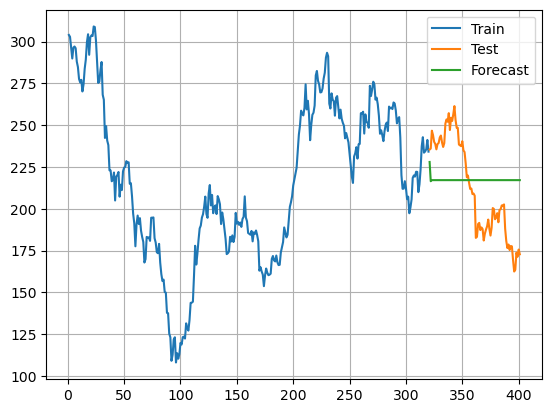

Mean Squared Error (MSE): 851.2357555239173
Mean Absolute Error (MAE): 26.64219939709449
Root Mean Squared Error (RMSE): 29.17594480944734


In [10]:
#Step 8: Forecasting

from sklearn.metrics import mean_absolute_error
import numpy as np

forecast = final_model.forecast(steps=len(test))
test['Forecast'] = forecast

plt.plot(train['Time'], train['Value'], label='Train')
plt.plot(test['Time'], test['Value'], label='Test')
plt.plot(test['Time'], test['Forecast'], label='Forecast')
plt.legend()
plt.grid()
plt.show()

# Forecast Evaluation Metrics
mse = mean_squared_error(test['Value'], test['Forecast'])
mae = mean_absolute_error(test['Value'], test['Forecast'])
rmse = np.sqrt(mse)

print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Root Mean Squared Error (RMSE): {rmse}")